## Twitter Data for Predicting Stock Returns

In [1]:
import re
import json
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
global stock_set
global positive_words, negative_words
price_csv = 'close_price.csv'
stock_set = ['IBM', 'MSFT', 'TSLA', "AMZN", "VZ"]
words_csv = 'LoughranMcDonald_MasterDictionary_2014.csv'
lmDic = pd.read_csv(words_csv)[['Word','Negative','Positive']]
positive_words = list(lmDic[lmDic['Negative']!=0]['Word'])
negative_words = list(lmDic[lmDic['Positive']!=0]['Word'])

In [3]:
class crack_twtr():
    def __init__(self):
        self.price_info = []
        self.twtr_ = []
        self.models = []
        self.predict_ = {}
        self.spark = SparkSession.builder.master("local[4]").appName("crack_twtr").getOrCreate()
        self.path_list = None
        self.plot_y = [] 
        self.plot_x = [] 
   
    def enter_price_csv(self, price_csv):
        self.price_info = pd.read_csv(price_csv, parse_dates=['Date'],\
                                      date_parser=lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y'))
        

    def get_twtr_path(self, price_info):
        twtr_path = []
        date_list = price_info['Date']
        for i in date_list:
            twtr_path.append("{:02d}/{:02d}/*/*.json.bz2".format(i.month,i.day))
        return twtr_path    

    def twtr_analyze(self):
        self.path_list = self.get_twtr_path(self.price_info) ##
        
        def extract_features(twtr_line):
            twtr_line = str(twtr_line)
            split_line = twtr_line.split(", ")
            text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(text=u)"," ", split_line[1])
            
            info_set = {}
            for s in stock_set:
                info_set.update({s:{"followers_count":0, "p_count":0, "n_count":0, "mentioned_count": 0}})
                   
            for s in stock_set:
                if (s in text) or (s.lower() in text):
                    info_set[s]['followers_count'] = filter(str.isdigit, split_line[0])
                    info_set[s]['mentioned_count'] = 1

                    split_text = text.split()

                    for st in split_text:
                        st = st.upper()
                        if st in positive_words:
                            info_set[s]['p_count'] += 1
                        elif st in negative_words:
                            info_set[s]['n_count'] += 1
                        else:
                            pass
            return info_set
    
        def aggragete_result(r1, r2):
            for s in stock_set:
                r1[s]["followers_count"] = int(r1[s]["followers_count"]) + int(r2[s]["followers_count"]) 
                r1[s]["mentioned_count"] = int(r1[s]["mentioned_count"]) + int(r2[s]["mentioned_count"]) 
                r1[s]["n_count"] = int(r1[s]["n_count"]) + int(r2[s]["n_count"]) 
                r1[s]["p_count"] = int(r1[s]["p_count"]) + int(r2[s]["p_count"]) 
            return r1
        
        for i in self.path_list:  ## the first feature is the params
            twtr = self.spark.read.json(i)
            twtr_en = twtr.filter(twtr['lang'] == 'en')
            twtr_target = twtr_en.select(twtr_en['user']['followers_count'],twtr_en['text'])
            self.twtr_.append(twtr_target.rdd.map(extract_features).reduce(aggragete_result))
            
        # regression
        for s in stock_set:
            X = []
            for f in self.twtr_[1:]:
                X.append([1, f[s]['followers_count']/1000., f[s]['mentioned_count'], f[s]['p_count'], f[s]['n_count']])
            pp = self.twtr_[0]
            predicting_param = [1, pp[s]['followers_count']/1000., pp[s]['mentioned_count'], pp[s]['p_count'], pp[s]['n_count']]
            pricetmp = self.price_info[['Date', s]]
            pricetmp1 = pricetmp[s].diff()/ pricetmp[s]
            returns = list(pricetmp1[~pricetmp1.isnull()])
            model = sm.OLS(returns, X).fit()
            self.models.append(model)
            self.plot_y = returns
            self.plot_x = X
            predicted_returns = model.predict(predicting_param)
            predicted_price = (predicted_returns+1)*self.price_info[s][0]
            self.predict_.update({s:{"predict_return":predicted_returns,"predict_price":predicted_price}})
            
    def show_plot(self, n):
        index = range(1,len(self.plot_y)+1)
        plot_y_fit = [float(self.models[n].predict(self.plot_x[i])) for i in xrange(0,len(self.plot_y))]
        plt.plot(index, self.plot_y, 'r-.', label = "real_value")
        plt.plot(index, plot_y_fit, 'b--', label = "fitted_value")
        plt.xlabel('Time')
        plt.ylabel('Returns')
        plt.legend()
        plt.show()

In [4]:
task = crack_twtr()
task.enter_price_csv(price_csv)
task.twtr_analyze()

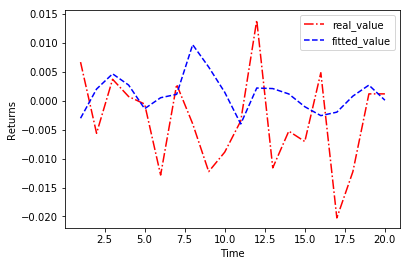

In [33]:
task.show_plot()

In [34]:
task.models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     3.680
Date:                Sun, 26 Mar 2017   Prob (F-statistic):             0.0279
Time:                        04:04:54   Log-Likelihood:                 75.214
No. Observations:                  20   AIC:                            -140.4
Df Residuals:                      15   BIC:                            -135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0006      0.004      0.145      0.886        -0.008     0.009
x1          2.028e-06   3.45e-06      0.588      0.565     -5.32e-06  9.38e-06
x2         -8.255e-05    9.3e-05     -0.888      0.389        -0.000     0.000
x3            -0.0006      0.000     -3.539      0.003        -0.001    -0.000
x4             0.0009      0.001      1.585      0.134        -0.000     0.002
==============================================================================
Omnibus:                        0.887   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.642   Jarque-Bera (JB):                0.411
Skew:                          -0.350   Prob(JB):                        0.814
Kurtosis:                       2.939   Cond. No.                     1.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### From above plot and chart, we can see twitter data plays an important role of predicting stock returns. With more data, the effect would be better.